# KerasCV로 분류하기

**저자:** [lukewood](https://twitter.com/luke_wood_ml)  
**생성일:** 2023/03/28  
**최종편집일:** 2023/03/28  
**설명:** KerasCV를 사용하여 강력한 이미지 분류기를 트레이닝하세요.

분류는 주어진 입력 이미지에 대한 카테고리형 레이블을 예측하는 프로세스입니다.
분류는 비교적 간단한 컴퓨터 비전 작업이지만,
최신 접근 방식은 여전히 ​​여러 복잡한 구성 요소로 구성되어 있습니다.
다행히도, KerasCV는 일반적으로 사용되는 구성 요소를 구성하는 API를 제공합니다.

이 가이드는 세 가지 레벨의 복잡성에서,
이미지 분류 문제를 해결하는 KerasCV의 모듈식 접근 방식을 보여줍니다.

* 사전 트레이닝된 분류기를 사용한 추론
* 사전 트레이닝된 백본 미세 조정
* 처음부터 이미지 분류기 트레이닝

KerasCV는 Keras 3를 사용하여 TensorFlow, PyTorch 또는 Jax로 작동합니다.
아래 가이드에서는 `jax` 백엔드를 사용합니다.
이 가이드는 변경 사항 없이 TensorFlow 또는 PyTorch 백엔드에서 실행되므로,
아래의 `KERAS_BACKEND`를 업데이트하기만 하면 됩니다.

공식 Keras 마스코트인 Professor Keras를 자료의 복잡성에 대한 시각적 참조로 사용합니다.

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_evolution.png)

In [1]:
# 이 노트북은 Keras cv가 설치되어 있다는 가정 하에 진행됩니다.
# 이 노트북은 Keras 3이 설치되어 있다는 가정 하에 진행됩니다.
#
# !pip install -q --upgrade keras-cv
# !pip install -q --upgrade keras  # Upgrade to Keras 3.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics

import keras_cv

# [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) 및
# 해당 전처리 함수를 위해 tensorflow를 import 합니다.
import tensorflow as tf
import tensorflow_datasets as tfds

## 사전 트레이닝된 분류기를 사용한 추론

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_beginner.png)

가장 간단한 KerasCV API인 사전 트레이닝된 분류기로 시작해 보겠습니다.
이 예에서는, ImageNet 데이터 세트에 대해 사전 트레이닝된 분류기를 구성합니다.
이 모델을 사용하여 오래된 "Cat or Dog" 문제를 해결합니다.

KerasCV의 가장 높은 레벨의 모듈은 _task_ 입니다.
_task_ 는 (일반적으로 사전 트레이닝된) 백본 모델과 작업별 레이어로 구성된 [`keras.Model`](https://codecompose7.github.io/keras-doc-kr.github.io/api/models/model#model-class)입니다.
다음은 EfficientNetV2B0 백본과 함께 [`keras_cv.models.ImageClassifier`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/models/tasks/image_classifier#imageclassifier-class)를 사용하는 예입니다.

EfficientNetV2B0은 이미지 분류 파이프라인을 구성할 때 좋은 시작 모델입니다.
이 아키텍처는 7M의 매개변수 수를 사용하면서도 높은 정확도를 달성합니다.
EfficientNetV2B0가 해결하고자 하는 작업에 충분히 강력하지 않다면,
[KerasCV의 다른 사용 가능한 백본](https://github.com/keras-team/keras-cv/tree/master/keras_cv/models/backbones)을 확인하세요!

In [3]:
classifier = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet_classifier"
)

100%|██████████| 2.80k/2.80k [00:00<00:00, 1.10MB/s]
100%|██████████| 28.0M/28.0M [00:03<00:00, 9.73MB/s]


이전 `keras.applications` API에서 약간 차이가 있음을 알 수 있습니다.
이전 API에서는 `EfficientNetV2B0(weights="imagenet")`로 클래스를 구성했습니다.
이전 API는 분류에 매우 좋았지만, 객체 감지 및 시맨틱 세그멘테이션과 같이,
복잡한 아키텍처가 필요한 다른 사용 사례에는 효과적으로 확장되지 않았습니다.

이제 분류기가 구축되었으니, 이 귀여운 고양이 사진에 적용해 보겠습니다!

45500/45500 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


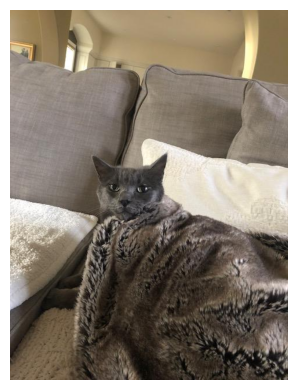

In [4]:
# filepath = keras.utils.get_file(origin="https://i.imgur.com/9i63gLN.jpg")
filepath = keras.utils.get_file(origin="https://github.com/tenkeyless/keras-io_test/blob/main/assets/9i63gLN.jpeg?raw=true")
image = keras.utils.load_img(filepath)
image = np.array(image)
keras_cv.visualization.plot_image_gallery(
    np.array([image]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4
)

다음으로, 분류기로부터 몇 가지 예측을 얻어 보겠습니다.

In [5]:
predictions = classifier.predict(np.expand_dims(image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


예측은 소프트맥스된 카테고리 순위의 형태로 제공됩니다.
간단한 argsort 함수를 사용하여, 상위 클래스의 인덱스를 찾을 수 있습니다.

In [6]:
top_classes = predictions[0].argsort(axis=-1)

클래스 매핑을 디코딩하기 위해,
카테고리 인덱스에서 ImageNet 클래스 이름으로 매핑을 구성할 수 있습니다.
편의상, ImageNet 클래스 매핑을 GitHub gist에 저장했습니다.
지금 다운로드하여 로드해 보겠습니다.

In [7]:
classes = keras.utils.get_file(
    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"
)
with open(classes, "rb") as f:
    classes = json.load(f)

33567/33567 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


이제 우리는 인덱스를 통해 간단히 클래스 이름을 조회할 수 있습니다.

In [8]:
top_two = [classes[str(i)] for i in top_classes[-2:]]
print("Top two classes are:", top_two)

Top two classes are: ['Egyptian cat', 'velvet']


좋습니다! 둘 다 맞는 것 같습니다!
하지만 클래스 중 하나는 "Velvet"입니다.
우리는 Cats VS Dogs를 분류하려고 합니다.
벨벳 담요는 신경 쓰지 않습니다!

이상적으로는, 이미지가 고양이인지 개인지 판별하기 위한 계산만 수행하고,
모든 리소스를 이 작업에 전념하는 분류기를 갖게 될 것입니다.
이는 우리 자신의 분류기를 미세 조정하여 해결할 수 있습니다.

## 사전 트레이닝된 분류기 미세 조정

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_intermediate.png)

작업에 특화된 레이블이 지정된 이미지가 있는 경우,
커스텀 분류기를 미세 조정하면 성능이 향상될 수 있습니다.
Cats vs Dogs 분류기를 트레이닝하려면,
명시적으로 레이블이 지정된 Cat vs Dog 데이터를 사용하면,
일반 분류기보다 성능이 더 좋아야 합니다!
많은 작업의 경우, 관련 사전 트레이닝된 모델을 사용할 수 없습니다.
(예: 당신의 애플리케이션에 특화된 이미지 분류)

먼저 데이터를 로드하여 시작해 보겠습니다.

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.enable_progress_bar()

data, dataset_info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

num_classes = dataset_info.features["label"].num_classes

resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32)
    # 데이터 세트를 한 번만 반복하므로 이미지 크기를 정적으로 조정합니다.
    return resizing(image), tf.one_hot(label, num_classes)


# 배치의 다양성을 높이기 위해 데이터 세트를 셔플합니다.
# 10*BATCH_SIZE는 더 큰 머신이 더 큰 셔플 버퍼를 처리할 수 있다는 가정을 따릅니다.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

images = next(iter(train_dataset.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

Output hidden; open in https://colab.research.google.com to view.

야옹!

다음으로 모델을 구성해 보겠습니다.
사전 설정 이름에 imagenet을 사용한 것은,
백본이 ImageNet 데이터 세트에 대해 사전 트레이닝되었음을 나타냅니다.
사전 트레이닝된 백본은 잠재적으로 훨씬 더 큰 데이터 세트에서 추출한 패턴을 활용하여,
레이블이 지정된 예제에서 더 많은 정보를 추출합니다.

다음으로 분류기를 구성해 보겠습니다.

In [11]:
model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=2
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

100%|██████████| 1.79k/1.79k [00:00<00:00, 766kB/s]
100%|██████████| 23.1M/23.1M [00:02<00:00, 8.29MB/s]


여기서 우리의 분류기는 단순한 [`keras.Sequential`](https://codecompose7.github.io/keras-doc-kr.github.io/api/models/sequential#sequential-class)입니다.
남은 것은 `model.fit()`를 호출하는 것뿐입니다.

In [12]:
model.fit(train_dataset)

727/727 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.9041 - loss: 0.3508


미세 조정 후 모델이 어떻게 수행되는지 살펴보겠습니다.

In [13]:
predictions = model.predict(np.expand_dims(image, axis=0))

classes = {0: "cat", 1: "dog"}
print("Top class is:", classes[predictions[0].argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Top class is: cat


훌륭하네요. 모델이 이미지를 올바르게 분류한 것 같아요.

## 처음부터 분류기 트레이닝

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_advanced.png)

이제 분류에 대해 자세히 알아보았으니, 마지막 과제를 하나 해보겠습니다.
분류 모델을 처음부터 트레이닝하는 것입니다!
이미지 분류의 표준 벤치마크는 ImageNet 데이터 세트이지만,
라이선스 제약으로 인해 이 튜토리얼에서는 CalTech 101 이미지 분류 데이터 세트를 사용합니다.
이 가이드에서는 더 간단한 CalTech 101 데이터 세트를 사용하지만,
ImageNet에서는 동일한 트레이닝 템플릿을 사용하여 최신 수준에 가까운 점수를 얻을 수 있습니다.

데이터 로딩부터 시작해 보겠습니다.

In [14]:
NUM_CLASSES = 101
# 완전히 트레이닝하려면 에포크를 100~로 변경하세요.
EPOCHS = 1


def package_inputs(image, label):
    return {"images": image, "labels": tf.one_hot(label, NUM_CLASSES)}


train_ds, eval_ds = tfds.load(
    "caltech101", split=["train", "test"], as_supervised="true"
)
train_ds = train_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(BATCH_SIZE * 16)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



CalTech101 데이터 세트는 각 이미지의 크기가 다르기 때문에,
`ragged_batch()` API를 사용하여 각 개별 이미지의 모양 정보를 유지하면서 이를 배치 처리합니다.

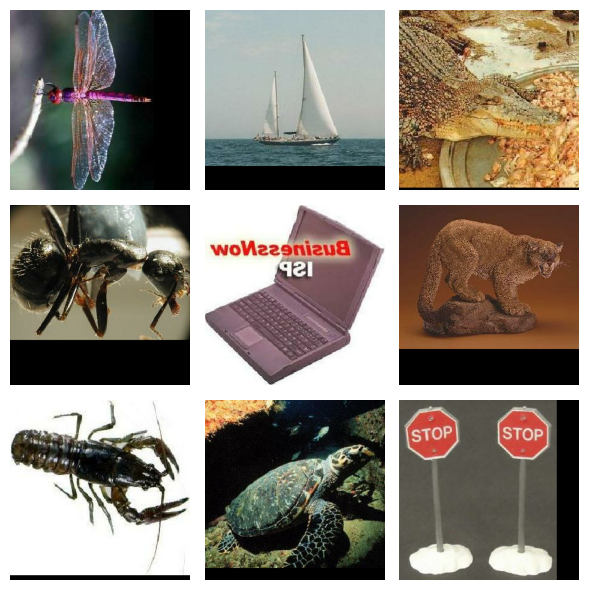

In [15]:
train_ds = train_ds.ragged_batch(BATCH_SIZE)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE)

batch = next(iter(train_ds.take(1)))
image_batch = batch["images"]
label_batch = batch["labels"]

keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

### 데이터 보강

이전 미세 조정 예제에서, 정적 크기 조정 작업을 수행했으며 이미지 보강을 활용하지 않았습니다.
그 이유는 트레이닝 세트에 대한 단일 패스로 적절한 결과를 얻기에 충분했기 때문입니다.
더 어려운 작업을 해결하기 위해, 트레이닝할 때는 데이터 파이프라인에 데이터 보강을 포함해야 합니다.

데이터 보강은 조명(lighting), 자르기(cropping), 방향(orientation)과 같은,
입력 데이터의 변경에 대해 모델을 견고하게 만드는 기술입니다.
KerasCV에는 `keras_cv.layers` API에서 가장 유용한 보강 중 일부가 포함되어 있습니다.
보강의 최적 파이프라인을 만드는 것은 예술이지만,
이 가이드의 이 섹션에서는 분류에 대한 모범 사례에 대한 몇 가지 팁을 제공합니다.

이미지 데이터 보강에 주의해야 할 한 가지 주의 사항은,
보강된 데이터 분포를 원래 데이터 분포에서 너무 멀리 옮기지 않도록 주의해야 한다는 것입니다.
목표는 과적합을 방지하고 일반화를 증가시키는 것이지만,
데이터 분포에서 완전히 벗어난 샘플은 단순히 트레이닝 과정에 노이즈를 추가합니다.

사용할 첫 번째 보강은 `RandomFlip`입니다. 이 보강은 예상한 대로 동작합니다.
즉, 이미지를 뒤집거나 뒤집지 않습니다.
이 보강은 CalTech101 및 ImageNet에서 유용하지만,
데이터 분포가 수직 거울 불변이 아닌 작업에는 사용해서는 안 됩니다.
이런 일이 발생하는 데이터 세트의 예로는 MNIST 손으로 쓴 숫자가 있습니다.
수직 축에서 `6`을 뒤집으면, 숫자가 `6`보다는 `7`처럼 보이지만, 레이블에는 여전히 `6`이 표시됩니다.

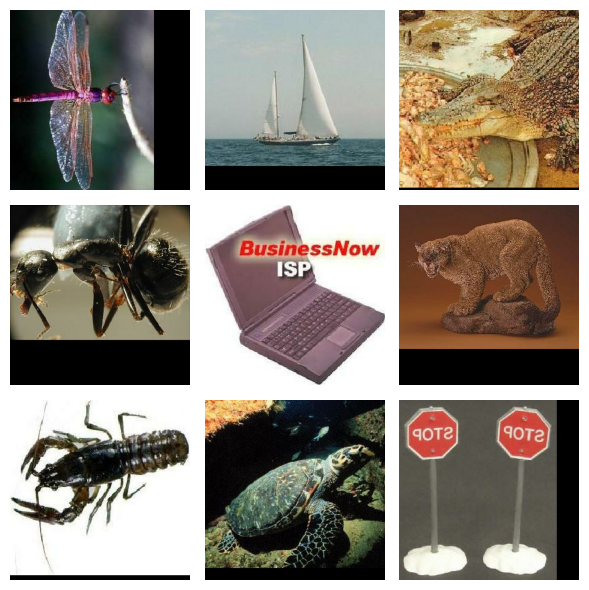

In [16]:
random_flip = keras_cv.layers.RandomFlip()
augmenters = [random_flip]

image_batch = random_flip(image_batch)
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

이미지의 절반이 뒤집혔습니다!

우리가 사용할 다음 보강은 `RandomCropAndResize`입니다.
이 작업은 이미지의 무작위 하위 집합을 선택한 다음, 제공된 대상 크기로 크기를 조정합니다.
이 보강을 사용하면 분류기가 공간적으로 불변이 되도록 강제합니다.
또한 이 레이어는 이미지의 종횡비를 왜곡하는 데 사용할 수 있는 `aspect_ratio_factor`를 허용합니다.
이렇게 하면, 모델 성능이 향상될 수 있지만 주의해서 사용해야 합니다.
종횡비 왜곡으로 인해 샘플이 원래 트레이닝 세트의 데이터 분포에서 너무 멀리 이동하기 쉽습니다. 기억하세요.
데이터 보강의 목표는 트레이닝 세트의 데이터 분포와 일치하는 더 많은 트레이닝 샘플을 생성하는 것입니다!

`RandomCropAndResize`는 또한 [`tf.RaggedTensor`](https://www.tensorflow.org/api_docs/python/tf/RaggedTensor) 입력을 처리할 수 있습니다.
CalTech101 이미지 데이터 세트에서 이미지는 다양한 크기로 제공됩니다.
따라서, 밀집된 트레이닝 배치로 쉽게 배치할 수 없습니다.
다행히도 `RandomCropAndResize`가 Ragged -> Dense 변환 프로세스를 처리합니다!

보강 세트에 `RandomCropAndResize`를 추가해 보겠습니다.

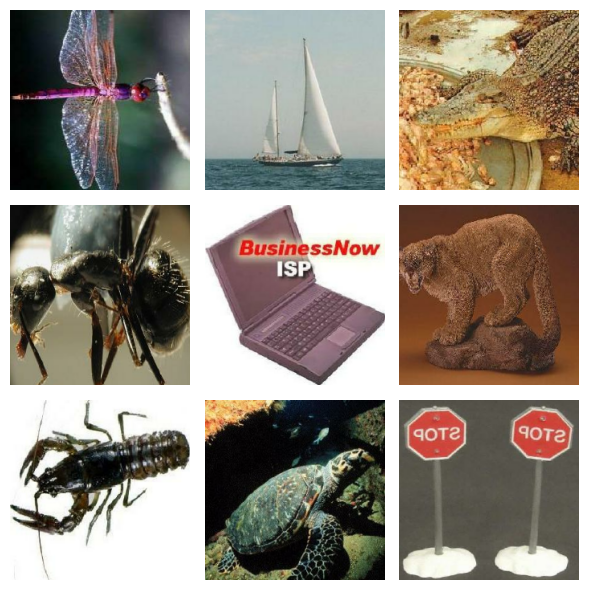

In [17]:
crop_and_resize = keras_cv.layers.RandomCropAndResize(
    target_size=IMAGE_SIZE,
    crop_area_factor=(0.8, 1.0),
    aspect_ratio_factor=(0.9, 1.1),
)
augmenters += [crop_and_resize]

image_batch = crop_and_resize(image_batch)
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

좋습니다! 이제 dense 이미지 배치로 작업합니다.
다음으로, 트레이닝 세트에 공간(spatial) 및 색상 기반 지터(color-based jitter)를 포함하겠습니다.
그러면, 조명 깜빡임, 그림자 등에 견고한 분류기를 생성할 수 있습니다.

색상과 공간적 특징을 변경하여 이미지를 보강하는 방법은 무한하지만,
아마도 가장 실전에서 검증된 기술은 [`RandAugment`](https://arxiv.org/abs/1909.13719)일 것입니다.
`RandAugment`는 실제로 10가지 다른 보강 세트입니다.
`AutoContrast`, `Equalize`, `Solarize`, `RandomColorJitter`, `RandomContrast`, `RandomBrightness`, `ShearX`, `ShearY`, `TranslateX` 및 `TranslateY`.
추론 시간에 각 이미지에 대해 `num_augmentations` 보강기를 샘플링하고,
각 이미지에 대해 무작위 크기 요소를 샘플링합니다.
그런 다음, 이러한 보강을 순차적으로 적용합니다.

KerasCV는 `augmentations_per_image` 및 `magnitude` 매개변수를 사용하여,
이러한 매개변수를 쉽게 조정할 수 있도록 합니다!
한 번 돌려보죠:

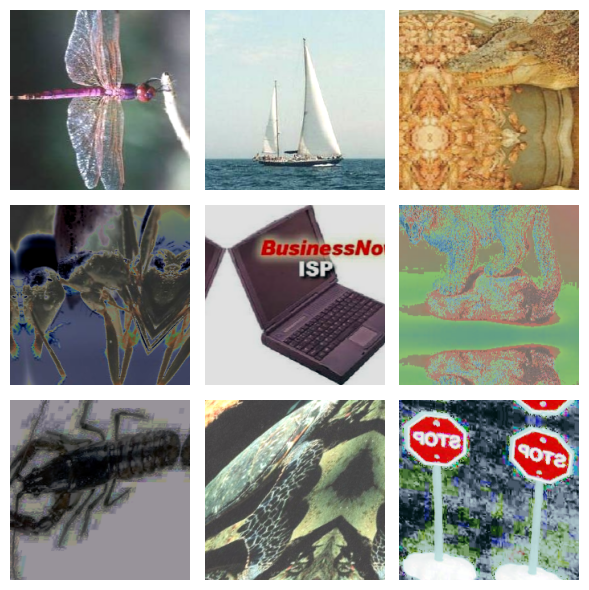

In [18]:
rand_augment = keras_cv.layers.RandAugment(
    augmentations_per_image=3,
    value_range=(0, 255),
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)
augmenters += [rand_augment]

image_batch = rand_augment(image_batch)
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

훌륭해 보이지만 아직 끝나지 않았습니다!
이미지에 클래스의 중요한 특징 하나가 없다면 어떨까요?
예를 들어, 잎이 고양이 귀를 가리고 있지만,
분류기가 고양이의 귀를 관찰하여 고양이를 분류하는 법을 배웠다면 어떨까요?

이 문제를 해결하는 쉬운 방법 중 하나는 `RandomCutout`을 사용하는 것입니다.
이 방법은 이미지의 하위 섹션을 무작위로 제거합니다.

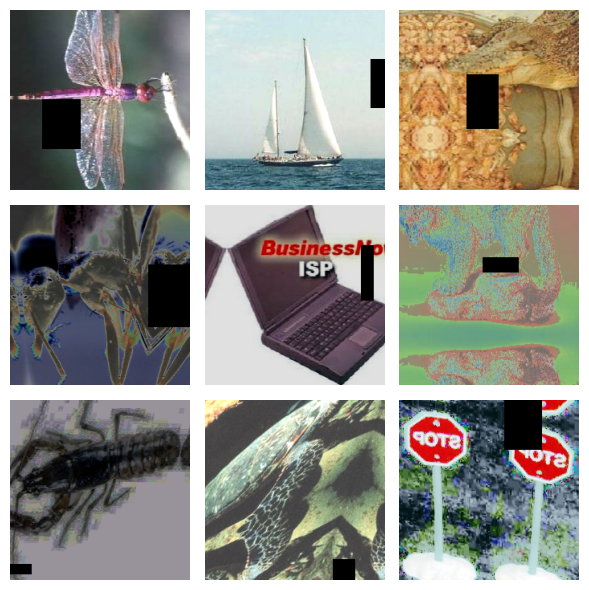

In [19]:
random_cutout = keras_cv.layers.RandomCutout(width_factor=0.4, height_factor=0.4)
keras_cv.visualization.plot_image_gallery(
    random_cutout(image_batch),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

이 방법은 문제를 비교적 잘 해결하지만,
분류기가 잘린 부분에 의해 발생한 특징과 검은색 픽셀 영역 사이의 경계에 대한 반응을 개발하게 할 수 있습니다.

[`CutMix`](https://arxiv.org/abs/1905.04899)는 더 복잡하고 효과적인 기술을 사용하여 같은 문제를 해결합니다.
잘린 부분을 검은색 픽셀로 대체하는 대신,
`CutMix`는 이러한 영역을 트레이닝 세트 내에서 샘플링한 다른 이미지의 영역으로 대체합니다!
이 대체에 따라, 이미지의 분류 레이블이 원본과 혼합된 이미지의 클래스 레이블을 혼합하여 업데이트됩니다.

실제로는 어떻게 보일까요? 확인해 보겠습니다.

In [20]:
# cut_mix = keras_cv.layers.CutMix()
# # CutMix는 이미지와 레이블을 모두 수정해야 합니다.
# inputs = {"images": image_batch, "labels": label_batch}

# keras_cv.visualization.plot_image_gallery(
#     cut_mix(inputs)["images"],
#     rows=3,
#     cols=3,
#     value_range=(0, 255),
#     show=True,
# )

ValueError: In a nested call() argument, you cannot mix tensors and non-tensors. Received invalid mixed argument: inputs={'images': Array([[[[ 42.145878 ,  46.745396 ,  45.25754  ],
         [ 41.25461  ,  44.6891   ,  43.78376  ],
         [ 41.111645 ,  44.35926  ,  43.54736  ],
         ...,
         [113.61932  , 111.995514 , 120.92645  ],
         [113.99128  , 112.36747  , 121.29842  ],
         [114.99371  , 113.3699   , 122.30086  ]],

        [[ 42.145878 ,  46.745396 ,  45.25754  ],
         [ 41.25461  ,  44.6891   ,  43.78376  ],
         [ 41.111645 ,  44.35926  ,  43.54736  ],
         ...,
         [113.060005 , 111.436195 , 120.36715  ],
         [113.346405 , 111.722595 , 120.65354  ],
         [114.00957  , 112.38576  , 121.316696 ]],

        [[ 42.145878 ,  46.745396 ,  45.25754  ],
         [ 41.25461  ,  44.6891   ,  43.78376  ],
         [ 41.111645 ,  44.35926  ,  43.54736  ],
         ...,
         [117.30904  , 115.68523  , 124.61618  ],
         [117.351974 , 115.728165 , 124.65912  ],
         [117.724236 , 116.100426 , 125.03138  ]],

        ...,

        [[ 38.154587 ,  41.402206 ,  42.21411  ],
         [ 38.154587 ,  41.402206 ,  42.21411  ],
         [ 38.154587 ,  41.402206 ,  42.21411  ],
         ...,
         [203.46042  , 214.01518  , 197.77708  ],
         [203.9517   , 214.50647  , 198.26839  ],
         [204.66158  , 215.25127  , 198.90843  ]],

        [[ 38.95346  ,  42.20108  ,  43.012985 ],
         [ 38.95346  ,  42.20108  ,  43.012985 ],
         [ 38.95346  ,  42.20108  ,  43.012985 ],
         ...,
         [202.39684  , 212.97939  , 196.6579   ],
         [203.02568  , 213.82167  , 196.85991  ],
         [203.51572  , 214.72612  , 196.52112  ]],

        [[ 41.147327 ,  44.394947 ,  45.206852 ],
         [ 41.147327 ,  44.394947 ,  45.206852 ],
         [ 41.147327 ,  44.394947 ,  45.206852 ],
         ...,
         [201.95883  , 212.51372  , 197.29198  ],
         [202.26231  , 212.81818  , 196.57681  ],
         [202.89238  , 213.48486  , 197.13362  ]]],


       [[[204.10168  , 227.39633  , 237.46765  ],
         [204.10168  , 227.39633  , 237.46765  ],
         [204.26395  , 227.7472   , 237.27448  ],
         ...,
         [215.54422  , 237.74277  , 238.34317  ],
         [214.83606  , 237.01913  , 237.65887  ],
         [213.14542  , 235.2916   , 236.02518  ]],

        [[206.80878  , 230.16254  , 240.08356  ],
         [206.80878  , 230.16254  , 240.08356  ],
         [206.80878  , 230.34756  , 239.73358  ],
         ...,
         [214.01718  , 236.1824   , 236.86758  ],
         [213.30902  , 235.45877  , 236.18326  ],
         [211.61835  , 233.73123  , 234.54956  ]],

        [[207.22192  , 230.58466  , 240.48276  ],
         [207.22192  , 230.58466  , 240.48276  ],
         [207.37506  , 230.92618  , 240.28076  ],
         ...,
         [212.34863  , 234.47748  , 235.25528  ],
         [211.5245   , 233.63531  , 234.4589   ],
         [210.5488   , 232.6383   , 233.51602  ]],

        ...,

        [[121.508766 , 160.49664  , 175.47485  ],
         [108.746254 , 147.45566  , 163.14227  ],
         [ 99.98994  , 138.50827  , 154.68094  ],
         ...,
         [ 58.232674 ,  97.18567  , 109.23966  ],
         [ 54.53376  ,  93.40605  , 105.66534  ],
         [ 57.992836 ,  96.9406   , 109.0079   ]],

        [[ 89.10926  , 127.39018  , 144.16681  ],
         [ 77.55787  , 115.58675  , 133.00458  ],
         [ 71.45103  , 109.34665  , 127.10345  ],
         ...,
         [ 59.1513   ,  98.12433  , 110.12731  ],
         [ 59.277138 ,  98.25293  , 110.248924 ],
         [ 60.59852  ,  99.603134 , 111.52578  ]],

        [[ 80.26215  , 118.35004  , 135.61774  ],
         [ 70.670906 , 108.549484 , 126.34962  ],
         [ 63.01229  , 100.723755 , 118.949    ],
         ...,
         [ 53.46305  ,  92.312    , 104.630714 ],
         [ 60.114998 ,  99.10907  , 111.05857  ],
         [ 61.213448 , 100.231476 , 112.11999  ]]],


       [[[169.30664  , 160.95448  , 109.817    ],
         [167.03438  , 158.75415  , 107.487274 ],
         [169.21574  , 160.33055  , 109.187515 ],
         ...,
         [ 97.43437  ,  72.762276 ,  28.77646  ],
         [124.41335  ,  99.91323  ,  56.146774 ],
         [182.71822  , 157.621    , 113.6733   ]],

        [[177.48663  , 170.32826  , 116.7214   ],
         [182.86026  , 176.2419   , 123.5402   ],
         [191.42648  , 184.07361  , 132.6284   ],
         ...,
         [110.71977  ,  87.97201  ,  45.090256 ],
         [143.97633  , 121.12529  ,  76.357574 ],
         [177.28342  , 153.56212  , 107.58432  ]],

        [[193.93878  , 186.20595  , 134.11607  ],
         [194.12506  , 186.64372  , 135.64648  ],
         [201.67542  , 193.86261  , 144.13884  ],
         ...,
         [137.16579  , 115.60231  ,  72.86379  ],
         [165.38506  , 142.96097  ,  98.04667  ],
         [141.35986  , 117.92014  ,  71.449905 ]],

        ...,

        [[144.3069   ,  90.38308  ,  26.941904 ],
         [155.8683   , 102.29978  ,  37.95396  ],
         [171.68286  , 117.54556  ,  52.85764  ],
         ...,
         [ 97.94369  ,  63.577507 ,  30.504698 ],
         [100.730255 ,  66.56873  ,  33.298023 ],
         [103.65546  ,  69.82294  ,  36.369625 ]],

        [[179.69817  , 126.56646  ,  60.835915 ],
         [172.4703   , 120.72173  ,  54.185863 ],
         [186.26962  , 133.55302  ,  66.89479  ],
         ...,
         [118.27381  ,  83.17746  ,  45.172016 ],
         [115.14308  ,  80.40682  ,  42.21447  ],
         [119.988495 ,  85.8458   ,  47.355366 ]],

        [[207.23433  , 154.29686  ,  87.70545  ],
         [197.35986  , 146.25331  ,  78.881134 ],
         [198.52748  , 147.31197  ,  79.00056  ],
         ...,
         [147.43988  , 110.7859   ,  67.02288  ],
         [152.52324  , 115.903885 ,  72.19325  ],
         [142.91522  , 106.9765   ,  63.797413 ]]],


       ...,


       [[[109.25992  , 171.06499  ,  86.209564 ],
         [105.34798  , 163.73369  ,  82.09538  ],
         [ 95.52583  , 151.08218  ,  72.19157  ],
         ...,
         [ 64.15889  , 121.637375 ,  38.6538   ],
         [ 62.27307  , 117.22435  ,  39.29696  ],
         [ 60.784058 , 114.55945  ,  42.12909  ]],

        [[114.91603  , 176.56917  ,  91.764404 ],
         [108.88335  , 167.00365  ,  85.139145 ],
         [ 97.64446  , 153.26126  ,  74.18933  ],
         ...,
         [ 60.84491  , 118.32341  ,  35.33982  ],
         [ 60.433372 , 115.38463  ,  37.457245 ],
         [ 60.418602 , 114.194    ,  41.76364  ]],

        [[118.384964 , 178.7135   ,  93.90872  ],
         [109.296906 , 167.41722  ,  85.552704 ],
         [ 96.583755 , 152.20053  ,  73.1286   ],
         ...,
         [ 61.14885  , 118.62735  ,  35.64377  ],
         [ 60.99932  , 115.95058  ,  38.02321  ],
         [ 62.458824 , 116.23424  ,  43.803864 ]],

        ...,

        [[ 22.98335  ,  87.79255  ,   3.5931873],
         [ 33.45334  , 100.086555 ,  14.063166 ],
         [  4.853323 ,  75.29567  ,   0.       ],
         ...,
         [ 35.91432  ,  99.3842   ,  16.04677  ],
         [ 28.29191  ,  99.43797  ,   9.991766 ],
         [ 54.815956 , 131.48683  ,  37.72886  ]],

        [[ 27.717566 ,  93.29936  ,   6.477785 ],
         [ 37.729553 , 106.15141  ,  18.28103  ],
         [  2.4937801,  72.94331  ,   0.       ],
         ...,
         [ 74.44121  , 140.43867  ,  58.71353  ],
         [ 40.62256  , 113.09454  ,  23.701807 ],
         [ 34.907433 , 115.03873  ,  21.311613 ]],

        [[ 29.19385  ,  94.841385 ,   5.683607 ],
         [ 37.641487 , 106.229324 ,  16.091436 ],
         [  0.       ,  66.63737  ,   0.       ],
         ...,
         [ 21.764929 ,  90.577126 ,   7.941637 ],
         [ 12.970537 ,  88.65645  ,   0.       ],
         [ 21.61162  , 103.82204  ,  10.098711 ]]],


       [[[161.39055  , 147.98672  , 129.1901   ],
         [163.5789   , 149.42953  , 130.53934  ],
         [165.733    , 150.58998  , 131.58492  ],
         ...,
         [ 51.242584 ,  44.755497 ,  38.011864 ],
         [ 56.513344 ,  49.91316  ,  43.73703  ],
         [ 35.320362 ,  28.62696  ,  23.32127  ]],

        [[159.0315   , 146.4082   , 128.06721  ],
         [160.2368   , 146.9977   , 128.90724  ],
         [161.65846  , 147.60957  , 129.7752   ],
         ...,
         [ 45.59716  ,  41.305206 ,  35.97639  ],
         [ 30.205105 ,  26.465954 ,  21.178152 ],
         [ 34.765785 ,  31.626833 ,  24.09977  ]],

        [[157.64139  , 145.70874  , 127.18091  ],
         [159.21036  , 146.32414  , 128.0708   ],
         [160.53195  , 147.52306  , 129.23901  ],
         ...,
         [ 38.201015 ,  35.351276 ,  30.161325 ],
         [ 21.664    ,  19.03091  ,  13.6257105],
         [ 29.159452 ,  26.605917 ,  18.978447 ]],

        ...,

        [[130.44698  , 106.193825 ,  82.1248   ],
         [129.65851  , 100.77243  ,  77.21665  ],
         [129.25261  ,  94.23699  ,  71.64019  ],
         ...,
         [ 90.5353   ,  74.45733  ,  57.55459  ],
         [100.96443  ,  86.45345  ,  68.50421  ],
         [ 92.45337  ,  81.68057  ,  61.054707 ]],

        [[143.61366  , 125.044136 , 100.79435  ],
         [140.70595  , 119.29779  ,  95.86541  ],
         [139.35896  , 113.34285  ,  91.354454 ],
         ...,
         [101.011566 ,  91.05153  ,  72.312    ],
         [ 84.74022  ,  80.17475  ,  57.464615 ],
         [ 88.00647  ,  88.01133  ,  63.242725 ]],

        [[148.3459   , 131.76337  , 105.9147   ],
         [154.447    , 136.81131  , 111.43847  ],
         [156.76134  , 136.68825  , 112.75904  ],
         ...,
         [102.2384   ,  94.714424 ,  76.19557  ],
         [ 93.11036  ,  90.19736  ,  69.698    ],
         [ 90.17078  ,  91.234604 ,  69.88878  ]]],


       [[[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ]],

        [[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ]],

        [[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ]],

        ...,

        [[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ]],

        [[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ]],

        [[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ]]]], dtype=float32), 'labels': <tf.Tensor: shape=(32, 101), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>}

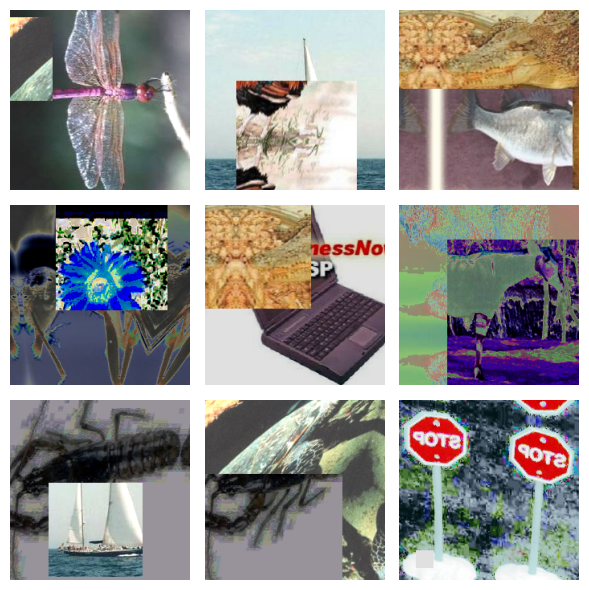

In [22]:
cut_mix = keras_cv.layers.CutMix()
# CutMix는 이미지와 레이블을 모두 수정해야 합니다.
# image_batch를 텐서로 변환합니다.
image_batch = tf.convert_to_tensor(image_batch)
inputs = {"images": image_batch, "labels": label_batch}

keras_cv.visualization.plot_image_gallery(
    cut_mix(inputs)["images"],
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

보강기에 추가하는 것을 잠시 미룹시다. 곧 자세히 설명하겠습니다!

다음으로, `MixUp()`을 살펴보겠습니다.
안타깝게도, `MixUp()`은 경험적으로 트레이닝된 모델의 견고성과 일반화를 _상당히_ 개선하는 것으로 나타났지만,
왜 이런 개선이 일어나는지는 잘 이해되지 않았습니다...
하지만 약간의 연금술은 누구에게도 해가 되지 않았습니다!

`MixUp()`은 배치에서 두 개의 이미지를 샘플링한 다음,
문자 그대로 픽셀 강도와 분류 레이블을 함께 혼합하여 작동합니다.

실제로 작동하는 모습을 살펴보겠습니다.

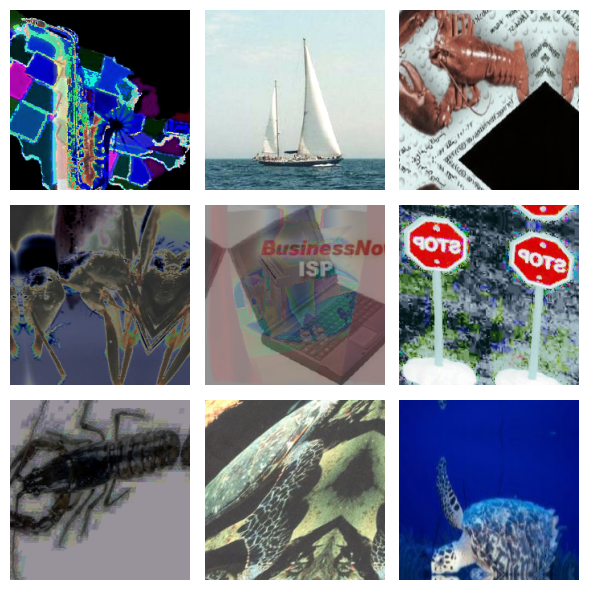

In [23]:
mix_up = keras_cv.layers.MixUp()
# MixUp은 이미지와 레이블을 모두 수정해야 합니다.
inputs = {"images": image_batch, "labels": label_batch}

keras_cv.visualization.plot_image_gallery(
    mix_up(inputs)["images"],
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

자세히 보면, 이미지가 혼합된 것을 볼 수 있습니다.

모든 이미지에 `CutMix()`와 `MixUp()`을 적용하는 대신,
각 배치에 적용할 하나를 선택합니다.
이는 `keras_cv.layers.RandomChoice()`를 사용하여 표현할 수 있습니다.

In [24]:
cut_mix_or_mix_up = keras_cv.layers.RandomChoice([cut_mix, mix_up], batchwise=True)
augmenters += [cut_mix_or_mix_up]

이제 최종 보강기를 트레이닝 데이터에 적용해 보겠습니다.

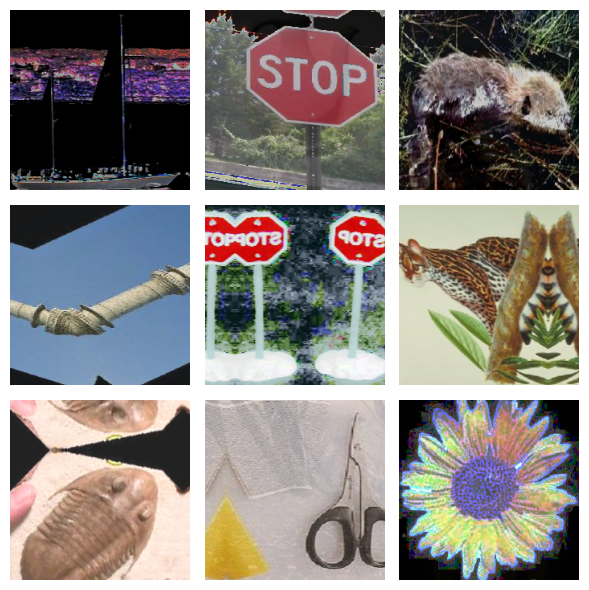

In [25]:
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)

image_batch = next(iter(train_ds.take(1)))["images"]
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

또한 모델에서 기대하는 이미지 크기의 dense 배치를 얻기 위해, 평가 세트의 크기를 조정해야 합니다.
이 경우 결정론적(deterministic) [`keras_cv.layers.Resizing`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/preprocessing/resizing#resizing-class)을 사용하여,
평가 메트릭에 노이즈를 추가하는 것을 방지합니다.

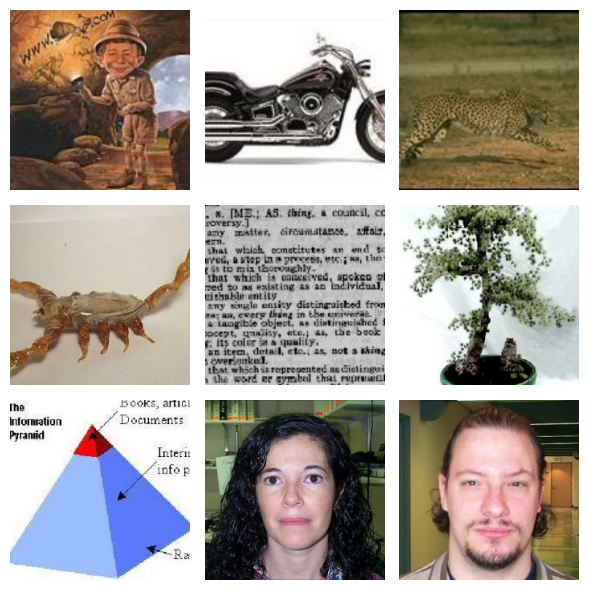

In [26]:
inference_resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

image_batch = next(iter(eval_ds.take(1)))["images"]
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

마지막으로, 데이터세트를 언패키지하고,
이를 `(images, labels)` 튜플을 받는 `model.fit()`에 전달할 준비를 합시다.

In [27]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]


train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

데이터 보강은 현대 분류기를 트레이닝하는 데 가장 어려운 부분입니다. 여기까지 온 것을 축하합니다!

### 옵티마이저 튜닝

최적의 성능을 달성하려면, 단일 학습률 대신 학습률 스케쥴을 사용해야 합니다.
여기서 사용된 워밍업 스케쥴을 사용한 코사인 감쇠에 대해서는 자세히 설명하지 않겠지만,
[여기에서 자세히 읽을 수 있습니다](https://scorrea92.medium.com/cosine-learning-rate-decay-e8b50aa455b).

In [28]:
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine 감쇠
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )

        return ops.where(step > self.total_steps, 0.0, lr)

![WarmUpCosineDecay schedule](https://i.imgur.com/YCr5pII.png)

스케쥴은 예상대로 보입니다.

다음으로 이 옵티마이저를 구성해 보겠습니다.

In [29]:
total_images = 9000
total_steps = (total_images // BATCH_SIZE) * EPOCHS
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)
optimizer = optimizers.SGD(
    weight_decay=5e-4,
    learning_rate=schedule,
    momentum=0.9,
)

마침내, 우리는 이제 모델을 빌드하고 `fit()`를 호출할 수 있습니다!
`keras_cv.models.EfficientNetV2B0Backbone()`은
`keras_cv.models.EfficientNetV2Backbone.from_preset('efficientnetv2_b0')`의 편의 별칭(convenience alias)입니다.
이 사전 설정에는 사전 트레이닝된 가중치가 제공되지 않습니다.

In [30]:
backbone = keras_cv.models.EfficientNetV2B0Backbone()
model = keras.Sequential(
    [
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(101, activation="softmax"),
    ]
)

100%|██████████| 1.77k/1.77k [00:00<00:00, 798kB/s]


MixUp()과 CutMix()로 생성된 레이블은 어느 정도 인위적이기 때문에,
이 보강 과정의 아티팩트로 인해 모델이 과적합되는 것을 방지하기 위해,
레이블 평활화(label smoothing)를 사용합니다.

In [31]:
loss = losses.CategoricalCrossentropy(label_smoothing=0.1)

모델을 컴파일해 보겠습니다.

In [32]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[
        metrics.CategoricalAccuracy(),
        metrics.TopKCategoricalAccuracy(k=5),
    ],
)

마지막으로 fit()을 호출합니다.

In [ ]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=eval_ds,
)

94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_accuracy: 0.0142 - loss: 6.2457 - top_k_categorical_accuracy: 0.0557

축하합니다! 이제 KerasCV에서 강력한 이미지 분류기를 처음부터 트레이닝하는 방법을 알게 되었습니다.
애플리케이션에 레이블이 지정된 데이터의 가용성에 따라,
처음부터 트레이닝하는 것이 위에서 설명한 데이터 보강 외에도 전이 학습을 사용하는 것보다
더 강력할 수도 있고 그렇지 않을 수도 있습니다.
더 작은 데이터 세트의 경우, 사전 트레이닝된 모델은 일반적으로 높은 정확도와 더 빠른 수렴을 생성합니다.


## 결론

이미지 분류는 아마도 컴퓨터 비전에서 가장 간단한 문제일지 몰라도,
현대적 환경에는 복잡한 구성 요소가 많이 있습니다.
다행히도, KerasCV는 이러한 구성 요소의 대부분을,
한 줄의 코드로 조립할 수 있는 강력한 프로덕션 등급 API를 제공합니다.
KerasCV의 `ImageClassifier` API, 사전 트레이닝된 가중치,
KerasCV 데이터 보강을 사용하면,
몇 백 줄의 코드로 강력한 분류기를 트레이닝하는 데 필요한 모든 것을 조립할 수 있습니다!

후속 연습으로 다음을 시도해 보세요.

* 자신의 데이터 세트에 대해 KerasCV 분류기를 미세 조정합니다.
* [KerasCV의 데이터 보강](https://codecompose7.github.io/keras-doc-kr.github.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/)에 대해 자세히 알아보세요.
* [ImageNet](https://github.com/keras-team/keras-cv/blob/master/examples/training/classification/imagenet/basic_training.py)에서 모델을 트레이닝하는 방법을 확인하세요.
